In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy
# import plotly as plt
import plotly.graph_objs as go
import seaborn as sns
%matplotlib inline

In [2]:
# read in the data
# path2data = Path.joinpath(Path.cwd().parent,'data','BorderCrossingEntryData.csv')
dataPath = Path.joinpath(Path.cwd(),'BorderCrossingEntryData.csv')
df = pd.read_csv(dataPath)
df.sample(3)

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
46712,Del Rio,Texas,2302,US-Mexico Border,4/1/2015 0:00,Truck Containers Empty,871,POINT (-100.93 29.330000000000002)
55321,Naco,Arizona,2603,US-Mexico Border,9/1/2014 0:00,Train Passengers,0,POINT (-109.95 31.33)
337191,Blaine,Washington,3004,US-Canada Border,8/1/1996 0:00,Rail Containers Full,3645,POINT (-122.74 49)


In [3]:
#df['Measure'].value_counts()

In [4]:
# Only interested in Passenger / Pedestrian crossings
people = df['Measure'].str.contains('Passengers|Pedestrians', case = False)

In [5]:
# Check to see how much data frame shrinks after filtering down
print(f'All measures: {df.shape}')
#df = df[people] # This gave index error when re-running, changed to df.loc
df = df.loc[people]
print(f'Just people: {df.shape}')

All measures: (346733, 8)
Just people: (115336, 8)


In [6]:
df.sample(3)

,Port Name,State,Port Code,Border,Date,Measure,Value,Location
100211,Maida,North Dakota,3416,US-Canada Border,11/1/2011 0:00,Personal Vehicle Passengers,1027,POINT (-98.37 49)
81698,Highgate Springs-Alburg,Vermont,212,US-Canada Border,2/1/2013 0:00,Train Passengers,46,POINT (-73.09 45.02)
63022,Willow Creek,Montana,3325,US-Canada Border,4/1/2014 0:00,Bus Passengers,0,POINT (-109.73 49)


In [7]:
# Drop unnecessary columns 
df.drop(['Port Code','Port Name'],axis=1,inplace=True)

In [8]:
df.sample(3)

,State,Border,Date,Measure,Value,Location
246419,Vermont,US-Canada Border,10/1/2002 0:00,Train Passengers,45,POINT (-72.66 45.02)
78194,Arizona,US-Mexico Border,4/1/2013 0:00,Train Passengers,0,POINT (-111.54 31.48)
69727,New Mexico,US-Mexico Border,11/1/2013 0:00,Pedestrians,11509,POINT (-106.68 31.78)


In [9]:
# are there any null values?
df.isnull().sum()

State       0
Border      0
Date        0
Measure     0
Value       0
Location    0
dtype: int64

In [10]:
# Break out Location into latitude and longitude
                # substring from 'POINT( ' to ')' and split on ' ' grabbing first then second element set as float
df['Latitude'] = df['Location'].str[len('POINT ('):-1].str.split(' ').str[1].astype(float)
df['Longitude'] = df['Location'].str[len('POINT ('):-1].str.split(' ').str[0].astype(float)

In [11]:
# Handle the Date column
df['newDate'] = pd.to_datetime(df['Date'])

In [12]:
# Inspect the date column
df['Year'] = df['newDate'].dt.year
df['Month'] = df['newDate'].dt.month
# How many years of data available?
maxYear = df['newDate'].dt.year.max()
minYear = df['newDate'].dt.year.min()
print(f'From {minYear} to {maxYear} for total of {maxYear-minYear} year(s) of data.')

From 1996 to 2019 for total of 23 year(s) of data.


In [19]:
# df.groupby(['Border','Year'])[['Value']].sum().head()
df = df.sample(10000)

,State,Border,Date,Measure,Value,Location,Latitude,Longitude,newDate,Year,Month
297816,Arizona,US-Mexico Border,4/1/1999 0:00,Pedestrians,336,POINT (-111.54 31.48),31.48,-111.54,1999-04-01,1999,4
337666,Vermont,US-Canada Border,8/1/1996 0:00,Train Passengers,0,POINT (-71.51 45.01),45.01,-71.51,1996-08-01,1996,8
52332,North Dakota,US-Canada Border,12/1/2014 0:00,Bus Passengers,0,POINT (-99.66 49),49.00,-99.66,2014-12-01,2014,12
338323,New York,US-Canada Border,7/1/1996 0:00,Bus Passengers,1392,POINT (-75.46 44.73),44.73,-75.46,1996-07-01,1996,7
121817,Maine,US-Canada Border,7/1/2010 0:00,Pedestrians,276,POINT (-68.33 47.36),47.36,-68.33,2010-07-01,2010,7


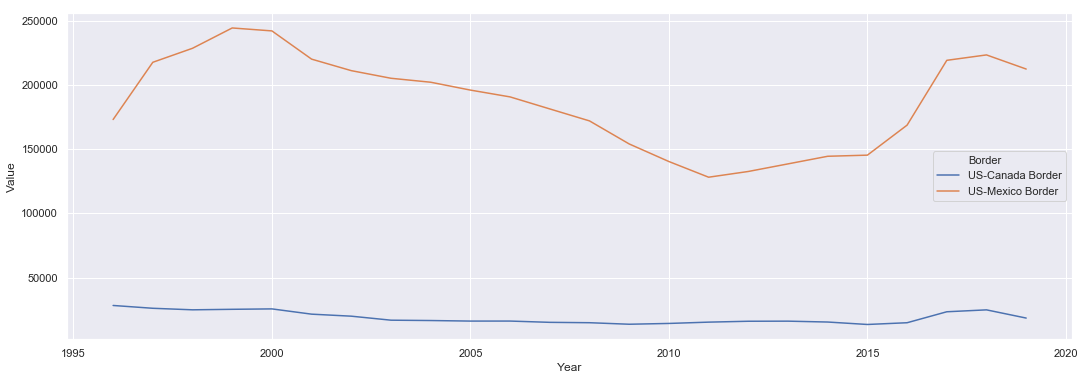

In [14]:
sns.set(rc={'figure.figsize':(18,6)})
sns.lineplot(x = 'Year', y = 'Value', hue = 'Border', ci=None, data = df);

In [21]:
mapbox_access_token = open("assets/mytoken.mapbox_token").read()

fig = go.Figure(go.Scattermapbox(
    lat=df['Latitude'],
    lon=df['Longitude'],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=20,
        colorscale='Purples',
        color=df['Value']
    ),
    text=df['Value']

))
fig.update_layout(
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=39.8283,
            lon=-98.5795
        ),
        pitch=0,
        zoom=3
    ),
)
fig

In [18]:
fig = go.Figure(data=go.Choropleth(
    locations=df['State'], # Spatial coordinates
    z = df['Value'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Pedestrians",
))

fig.update_layout(
    title_text = 'Migration',
    geo_scope='usa', # limite map scope to USA
)

fig.show()